In [6]:
import super_gradients

ModuleNotFoundError: No module named 'super_gradients'

In [1]:
import pycocotools

In [14]:
!pip install Cmake

   ---------------------------------------- 34.6/34.6 MB 18.2 MB/s eta 0:00:00


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [10]:
!pip install cython 

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [15]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to c:\users\talmeidar\appdata\local\temp\pip-req-build-p6ndt9_u
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pycocotools
Failed to build pycocotools


  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git 'C:\Users\talmeidar\AppData\Local\Temp\pip-req-build-p6ndt9_u'
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.9
      creating build\lib.win-amd64-3.9\pycocotools
      copying pycocotools\coco.py -> build\lib.win-amd64-3.9\pycocotools
      copying pycocotools\cocoeval.py -> build\lib.win-amd64-3.9\pycocotools
      copying pycocotools\mask.py -> build\lib.win-amd64-3.9\pycocotools
      copying pycocotools\__init__.py -> build\lib.win-amd64-3.9\pycocotools
      running build_ext
      building 'pycocotools._mask' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-

In [5]:
!pip install super-gradients

  Using cached super_gradients-3.3.1-py3-none-any.whl.metadata (37 kB)
  Using cached torch-2.1.0-cp39-cp39-win_amd64.whl.metadata (24 kB)
  Using cached boto3-1.28.75-py3-none-any.whl.metadata (6.7 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached coverage-5.3.1-cp39-cp39-win_amd64.whl (212 kB)
  Using cached torchvision-0.16.0-cp39-cp39-win_amd64.whl.metadata (6.6 kB)
  Using cached Sphinx-4.0.3-py3-none-any.whl (2.9 MB)
  Using cached sphinx_rtd_theme-1.3.0-py2.py3-none-any.whl.metadata (4.5 kB)
  Using cached torchmetrics-0.8.0-py3-none-any.whl (408 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached onnxruntime-1.13.1-cp39-cp39-win_amd64.whl (5.9 MB)
  Using cached onnx-1.13.0-cp39-cp39-win_amd64.whl (12.2 MB)
  Using cached pip_tools-7.3.0-py3-none-any.whl.metadata (23 kB)
  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)
  Using cached einops-0.3.2-

  error: subprocess-exited-with-error
  
  × Building wheel for pycocotools (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\pycocotools
      copying pycocotools\coco.py -> build\lib.win-amd64-cpython-39\pycocotools
      copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-39\pycocotools
      copying pycocotools\mask.py -> build\lib.win-amd64-cpython-39\pycocotools
      copying pycocotools\__init__.py -> build\lib.win-amd64-cpython-39\pycocotools
      running build_ext
      Compiling pycocotools/_mask.pyx because it changed.
      [1/1] Cythonizing pycocotools/_mask.pyx
      C:\Users\talmeidar\AppData\Local\Temp\pip-build-env-18leu1_4\overlay\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '


  Using cached json_tricks-3.16.1-py2.py3-none-any.whl (27 kB)
  Using cached onnx_simplifier-0.4.35-cp39-cp39-win_amd64.whl.metadata (4.4 kB)
  Using cached data_gradients-0.2.2-py3-none-any.whl.metadata (20 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
  Using cached numpy-1.23.0-cp39-cp39-win_amd64.whl (14.7 MB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)
  Using cached botocore-1.31.75-py3-none-any.whl.metadata (6.1 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.7.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached Pygments-2.16.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached platformdirs-3.11.0-py3-none-any.whl.metadata (11 kB)
  Using cached xhtml2pdf-0.2.11-py3-none-any.whl
  Using cached imagededup-0.3.2-cp39-cp39-win_amd64.whl (53 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached rich-13.6.0-py3-none-any.whl.

  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
INFO: pip is looking at multiple versions of tensorboard to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorboard-2.15.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached grpcio-1.59.2-cp39-cp39-win_amd64.whl.metadata (4.2 kB)
  Using cached google_auth_oauthlib-1.1.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached sphinxcontrib_jquery-4.1-py2.py3-none-any.whl (121 kB)
  Using cached google_auth-2.23.4-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached pyproject_hooks-1.0.0-py3-none-any.whl (9.3 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
  Using cached Pillow-10.1.0-cp39-cp39-win_amd64.whl.metadata (9.6 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached arabic_reshaper-3.0.0-py3-none-any.whl (20 kB)
  Using cached p

In [2]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

In [3]:
model = models.get(Models.YOLO_NAS_S, num_classes=3)

In [4]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from torchvision import transforms, utils
import numpy as np
import glob
import random


class CustomDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.lower()

        assert self.split in {'train', 'test'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        # with open(os.path.join(data_folder, self.split + '.txt'), 'r') as j:
        #     self.images = j.readlines()
        self.images = glob.glob(data_folder+"images/"+self.split+"/"+"*.jpg")
        self.images = [i.replace("\\","/") for i in self.images]
        self.images = random.sample(self.images,20)

    def __getitem__(self, i):
        # Read image and label
        image = Image.open(self.images[i].replace("\n","").replace("\\","/"), mode='r').resize((320, 320))
        image = image.convert("RGB")
        # image_tensor = torch.tensor(np.expand_dims(image,axis=-1)).permute(2, 0, 1).float()
        image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).float()
        labels = np.loadtxt(self.images[i].replace("jpg","txt").replace("images", "labels"))
        if len(labels.shape) == 1:
            labels = np.transpose(np.expand_dims(labels,axis=-1))
        return image_tensor, torch.tensor(labels,dtype=torch.float)
        

    def __len__(self):
        return len(self.images)

In [6]:
train_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="train")
val_dataset = CustomDataset("dataset_deteccao/axial_t1wce_2_class_corrigida/",split="test")

In [7]:
from torch.utils.data import Dataset, DataLoader
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=DetectionCollateFN())
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN())

In [8]:
from super_gradients.training import training_hyperparams

from prettyformatter import pprint

train_params = training_hyperparams.get('coco2017_yolo_nas_s')
print('Training parameters:')
pprint(train_params, json=True)

In [9]:
train_params['max_epochs'] = 1
# train_params['lr_warmup_epochs'] = 0
# train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 3
# train_params['average_best_models'] = False
# train_params['initial_lr'] = 0.01
# train_params['cosine_final_lr_ratio'] = 0.9
# train_params['mixed_precision'] = False
# train_params['phase_callbacks'] = []
# train_params['lr_warmup_steps'] = 10
# train_params['valid_metrics_list'] = [{"DetectionMetrics": {"post_prediction_callback": super_gradients.training.utils.ssd_utils.SSDPostPredictCallback(), "num_cls": 3}}]

In [36]:
pprint(train_params, json=True)

{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 3, "reg_max": 16},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics_list":
        [
    

In [11]:
from super_gradients.training import Trainer, MultiGPUMode

In [12]:
CHECKPOINT_DIR = '.'

In [13]:
super_gradients.setup_device(num_gpus=0)

Training parameters:
{
    "resume"    : null,
    "run_id"    : null,
    "resume_path"       : null,
    "resume_from_remote_sg_logger"      : false,
    "ckpt_name" : "ckpt_latest.pth",
    "lr_mode"   : "CosineLRScheduler",
    "lr_schedule_function"  : null,
    "lr_warmup_epochs"  : 0,
    "lr_warmup_steps"   : 1000,
    "lr_cooldown_epochs": 0,
    "warmup_initial_lr" : 1e-06,
    "step_lr_update_freq"   : null,
    "cosine_final_lr_ratio" : 0.1,
    "warmup_mode"       : "LinearBatchLRWarmup",
    "lr_updates": [],
    "pre_prediction_callback"   : null,
    "optimizer" : "AdamW",
    "optimizer_params"  : {"weight_decay": 1e-05},
    "load_opt_params"   : true,
    "zero_weight_decay_on_bias_and_bn"  : true,
    "loss"      : "PPYoloELoss",
    "criterion_params"  : {"use_static_assigner": false, "num_classes": 80, "reg_max": 16},
    "ema"       : true,
    "ema_params": {"decay": 0.9997, "decay_type": "threshold", "beta": 15},
    "train_metrics_list": [],
    "valid_metrics

[2023-10-31 17:50:17] WARNING - distributed_training_utils.py - CUDA device is not available on your device... Moving to CPU.


In [31]:
from super_gradients.training.processing import ImagePermute, ComposeProcessing

image_processor = ComposeProcessing(
    [
        # Resize(320),
        ImagePermute(permutation=(2, 0, 1)),
    ]
)


In [32]:
model.set_dataset_processing_params(iou=0.5,class_names=['negative','positive'],conf=0.5,image_processor=image_processor)

In [16]:
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolo_nas_s', ckpt_root_dir=CHECKPOINT_DIR)

In [33]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

[2023-10-31 18:06:12] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231031_180612_193611`
[2023-10-31 18:06:12] INFO - sg_trainer.py - Checkpoints directory: .\transfer_learning_object_detection_yolo_nas_s\RUN_20231031_180612_193611


The console stream is now moved to .\transfer_learning_object_detection_yolo_nas_s\RUN_20231031_180612_193611/console_Oct31_18_06_12.txt


[2023-10-31 18:06:12] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9997, 'decay_type': 'threshold', 'beta': 15}
[2023-10-31 18:06:12] WARNING - callbacks.py - Number of warmup steps (1000) is greater than number of steps in epoch (5). Warmup steps will be capped to number of steps in epoch to avoid interfering with any pre-epoch LR schedulers.
[2023-10-31 18:06:12] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         OFF
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            20         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5          (len(train_loader))
    - Gradient updates per epoch:   

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.0222
│   ├── Ppyoloeloss/loss_iou = 0.0
│   ├── Ppyoloeloss/loss_dfl = -0.0
│   └── Ppyoloeloss/loss = 0.0222
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0189
    ├── Ppyoloeloss/loss_iou = 0.0
    ├── Ppyoloeloss/loss_dfl = -0.0
    ├── Ppyoloeloss/loss = 0.0189
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0
    └── F1@0.50:0.95 = 0.0



[2023-10-31 18:06:55] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 1: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


[2023-10-31 18:07:14] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [18]:
val_dataset.__getitem__(0)[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [34]:
predicoes = model.predict(val_dataset.__getitem__(0)[0])

[2023-10-31 18:07:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


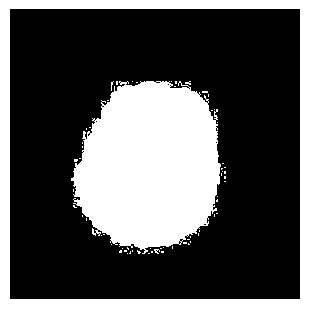

[2023-10-31 18:08:03] WARNING - image.py - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [35]:
predicoes.show()